In [6]:
# get data from kaggle's fire and smoke data set 
import os
os.listdir(os.getcwd())
!pip install -Uqq fastai duckduckgo_search

In [7]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [8]:
urls = search_images('man', max_images=1)
urls[0]

Searching for 'humans'


'https://tvseriesfinale.com/wp-content/uploads/2016/10/AMC_HUM_S1_Promo_Anita.jpg'

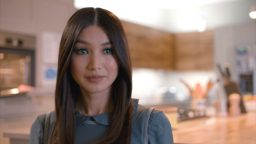

In [9]:
from fastdownload import download_url
dest = 'man.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [10]:
%config Completer.use_jedi = False

import os

SRC_IMAGES_DIR = '../input/d/ashutosh69/fire-and-smoke-dataset/data/data/img_data/train/'
    
def get_images(path):
    image_path = SRC_IMAGES_DIR + path
    return [os.path.abspath(os.path.join(image_path, p)) for p in os.listdir(image_path)]


fire_images = get_images('fire')
smoke_images = get_images('smoke')
# print(fire_images)

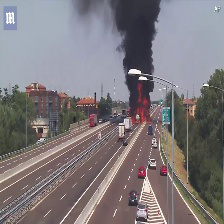

In [11]:
from fastai.vision.all import *
from fastcore.all import *
import random

im = Image.open(random.choice(fire_images))
im.to_thumb(256,256)

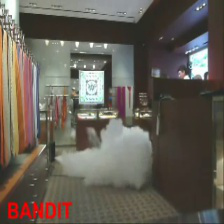

In [12]:
im = Image.open(random.choice(smoke_images))
im.to_thumb(256,256)

In [17]:
!rm -rf fire_or_not

path = Path('fire_or_not')
images = 'fire', 'smoke'

for o in images:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    resize_images(SRC_IMAGES_DIR + o, max_size=400, dest=path/o)

In [18]:
searches = 'man','background'
from time import sleep
location = (path / "other")
    
for o in searches:
    location.mkdir(exist_ok=True, parents=True)
    download_images(location, urls=search_images(f'{o} photo'))
    sleep(2)  # Pause between searches to avoid over-loading server
    download_images(location, urls=search_images(f'{o} sun photo'))
    sleep(2)
    download_images(location, urls=search_images(f'{o} shade photo'))
    sleep(2)
    resize_images(location, max_size=400, dest=location)

Searching for 'man photo'
Searching for 'man sun photo'
Searching for 'man shade photo'
Searching for 'background photo'
Searching for 'background sun photo'
Searching for 'background shade photo'


In [19]:
# print(path)
# os.listdir('./fire_or_not/smoke')

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

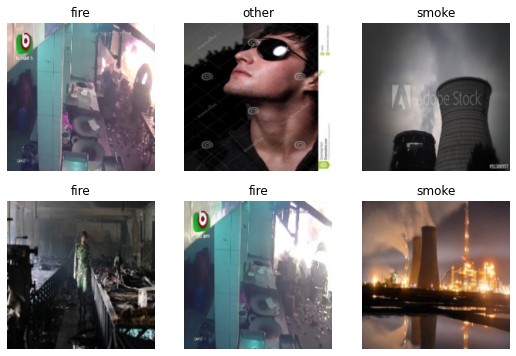

In [20]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [39]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/opt/conda/lib/python3.7/site-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,1.140055,0.361398,0.108491,00:57


epoch,train_loss,valid_loss,error_rate,time
0,0.422311,0.334402,0.117925,01:21
1,0.272584,0.367236,0.117925,01:21
2,0.178032,0.300851,0.094340,01:19
3,0.138374,0.345058,0.089623,01:19
4,0.105848,0.532539,0.117925,01:22
5,0.118204,0.610763,0.122642,01:22
6,0.095645,0.426015,0.084906,01:21
7,0.069376,0.507358,0.094340,01:22
8,0.066791,0.420901,0.113208,01:22
9,0.060732,0.488763,0.108491,01:21


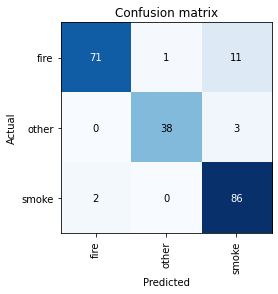

In [34]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [22]:
learn.export("./fso_model.pkl")
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('fso_model.pkl')]

In [26]:
model_inf = load_learner(path/'fso_model.pkl')
model_inf.predict(random.choice(get_image_files(Path("fire_or_not/fire"))))

('fire', tensor(0), tensor([9.9976e-01, 2.4312e-04, 7.0573e-07]))

In [36]:
chosen_image = random.choice(get_image_files(Path("fire_or_not/smoke")))

In [37]:
is_fire_accident,_,probs = learn.predict(chosen_image)
print(f"This is a: {is_fire_accident}.")
print(f"Probability it's a fire: {probs[0]:.4f}")

This is a: smoke.
Probability it's a fire: 0.0022


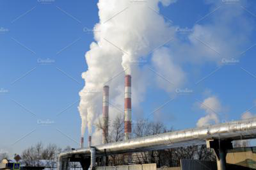

In [38]:
im=Image.open(chosen_image)
im.to_thumb(256,256)